# Hubbles Law

---

Utterslev, Copenhagen, Denmark  
December 19th, 2018

* Project by [Laura Bügel Groth](https://www.facebook.com/laura.bugelgroth)
* Jupyter Notebooks by [Rasmus Groth](https://github.com/bliiir)
* Inspiration from [zonination](https://www.reddit.com/r/dataisbeautiful/comments/5st2qn/i_got_a_dataset_of_4240_galaxies_and_calculated/)
* Mentoring by [Peter Lauersen](https://www.dark-cosmology.dk/~pela/index.html)

---

In the following we will use Python and data from [Leda](http://leda.univ-lyon1.fr/leda/fullsql.html), the database of physics of galaxies, to verify [Hubbles law](https://en.wikipedia.org/wiki/Hubble%27s_law):

## $v = H_0 \times d$

<div style="text-align: left">
    <table align="left">
        <tr>
            <th>Symbol</th>
            <th>Description</th>
            <th>Units</th>
            <th></th>
        </tr>
        <tr>
            <td> $v$  </td>
            <td> Velocity  </td>
            <td> Km/s</td>
            <td> Kilometer per second </td>
        </tr>
        <tr>
            <td>$H$ </td>
            <td>Hubbles constant</td>
            <td>Km/s/Mpc</td>
            <td>Kilometer per second per Megaparsec</td>
        </tr>
        <tr>
            <td>$d$ </td>
            <td>Distance</td>
            <td>Mpc</td>
            <td>Megaparsec</td>
        </tr>
    </table>
</div>

In other words, there is a linear relationship between the distance of a galaxy and it's speed relating to us - or that it follows the structure of a normal linear equation:

# $ y = a \times b + c $

---

## Import Python packages

In [1]:
import pandas as pd

import numpy as np
from numpy import log10,sqrt

import matplotlib.pyplot as plt

from astropy import units as u
from astropy.cosmology import Planck15
import astropy.constants as cc

from scipy.optimize import curve_fit

## Aquire the data

### Query
The following query was passed to the [leda database interface](http://leda.univ-lyon1.fr/leda/fullsql.html):

```
SELECT objname, v3k, mod0 WHERE (objtype='G') AND (v3k>3000) AND (v3k<30000) AND (mod0 IS NOT NULL) AND (v3k IS NOT NULL)
```

<div style="text-align: left">
    <table align="left">
        <tr>
            <th>Symbol</th>
            <th>Type</th>
            <th>Units</th>
            <th>Description</th>
        </tr>
        <tr>
            <td>mod0 </td>
            <td>float</td>
            <td>mag</td>
            <td>Distance modulus from distance measurements</td>
        </tr>
        <tr>
            <td>v3k</td>
            <td>float</td>
            <td>km/s</td>
            <td>Radial velocity (cz) with respect to the CMB radiation</td>
        </tr>
    </table>
</div>

We are elliminating objects that are not galaxies, (objtype='G'), objects with very low velocities (v3k>3000) because their local velocities and rotations skew the results, objects with very high velocities (v3k<30000) because the light we are getting from them only reflects their velocities in the early universe when the accelleration was significantly different.

The results were saved in a text file called, ```leda.txt``` locally and then loaded into a pandas dataframe in Python

In [2]:
# Load Leda data
df = pd.read_csv('leda.txt')

## Tidy the data

In [3]:
# Remove empty column at the end
df = df.iloc[:,0:3]

# Remove rows with missing values
df = df.dropna()

# Remove whitespace from the headers
df = df.rename(columns=lambda x: x.strip())

# Rename the objname column to galaxy
df = df.rename(columns={'objname':'galaxy'})

# Display a sample of the dataframe
df.head()

,galaxy,v3k,mod0
0,2MASXJ00024910+0045055,25649,37.28
1,2MASXJ01415126-0052365,27737,37.43
2,2MASXJ01270614+1906587,12621,36.10
3,2MASXJ01454460-5605518,26258,37.83
4,2MASXJ03372260-3302350,11603,35.73


---

## Luminosity Based Distance, $d_l$
Convert the magnitude (```mod0```) to [Luminosity-distance](https://en.wikipedia.org/wiki/Luminosity_distance) $d_l$ in parsec:

## $ d_l = 10^{\frac{m-M + 5}{5}}$

Where $ mod0 = m-M$

In [4]:
df['dl_mpc'] = 10**((df['mod0']+5)/5) / 1000000
df.head()

,galaxy,v3k,mod0,dl_mpc
0,2MASXJ00024910+0045055,25649,37.28,285.759054
1,2MASXJ01415126-0052365,27737,37.43,306.196343
2,2MASXJ01270614+1906587,12621,36.10,165.958691
3,2MASXJ01454460-5605518,26258,37.83,368.128974
4,2MASXJ03372260-3302350,11603,35.73,139.958732


## Physical Distance, $d$

The luminosity distance does not account for redshift and time dilation caused by differences in velocity and gravitational effects as the photons travel from the source to us. 

To get the proper distance, we first need the redshift factor, $z$, which we get by dividing the velocity with the speed of light (cc.c):

In [5]:
df['z'] = df['v3k'] / cc.c

And then we divide the luminosity distance, $d_l$, with the redshift factor $1 + z$:

In [6]:
# Calculate the proper redshift etc kompensated distance in parsec
df['d_mpc'] = df['dl_mpc'] / (1+df['z'])

In [7]:
df.head()

,galaxy,v3k,mod0,dl_mpc,z,d_mpc
0,2MASXJ00024910+0045055,25649,37.28,285.759054,0.000086,285.734608
1,2MASXJ01415126-0052365,27737,37.43,306.196343,0.000093,306.168016
2,2MASXJ01270614+1906587,12621,36.10,165.958691,0.000042,165.951704
3,2MASXJ01454460-5605518,26258,37.83,368.128974,0.000088,368.096733
4,2MASXJ03372260-3302350,11603,35.73,139.958732,0.000039,139.953316


---

## Export tidy dataset

In [8]:
# Save to file
df.to_csv('galaxies.csv')

---

## Best linear fit

In [9]:
def lin(x, a):
    return a * x

coeff, cov= curve_fit(lin, df['d_mpc'], df['v3k'])

# The slope of the best linear fit 
a = coeff[0]
a

66.59753735677145

---

## Age of the Universe

### Seconds

In [10]:
# Convert a from mpc based to km based
a_km = a / 1000000 / 30856775814913.67
age_sec = (1/a_km)
age_sec = age_sec
age_sec

4.6333208463264954e+17

### Years

In [11]:
# Age of the universe in years
age_year = age_sec / (60*60*24*365)
"{:,}".format(int(age_year))

'14,692,164,023'

---

## Tolerance

#### Co-variance

In [12]:
cov[0][0]

0.20239139101111292

### $R^2$

In [13]:
# Residual sum of squares (ss_tot)
residuals = df['v3k'] - lin(df['d_mpc'], coeff)
ss_res = np.sum(residuals**2)

# Total sum of squares (ss_tot)
ss_tot = np.sum((df['v3k']-np.mean(df['v3k']))**2)

# R squared
r_squared = 1 - (ss_res / ss_tot)
r_squared

0.7590999713188041

---

## Plot

In [14]:
# Store the distance in mpc in an array
x = df['d_mpc'].values

# Store the velocity in km/s in an array
y = df['v3k'].values # v3k

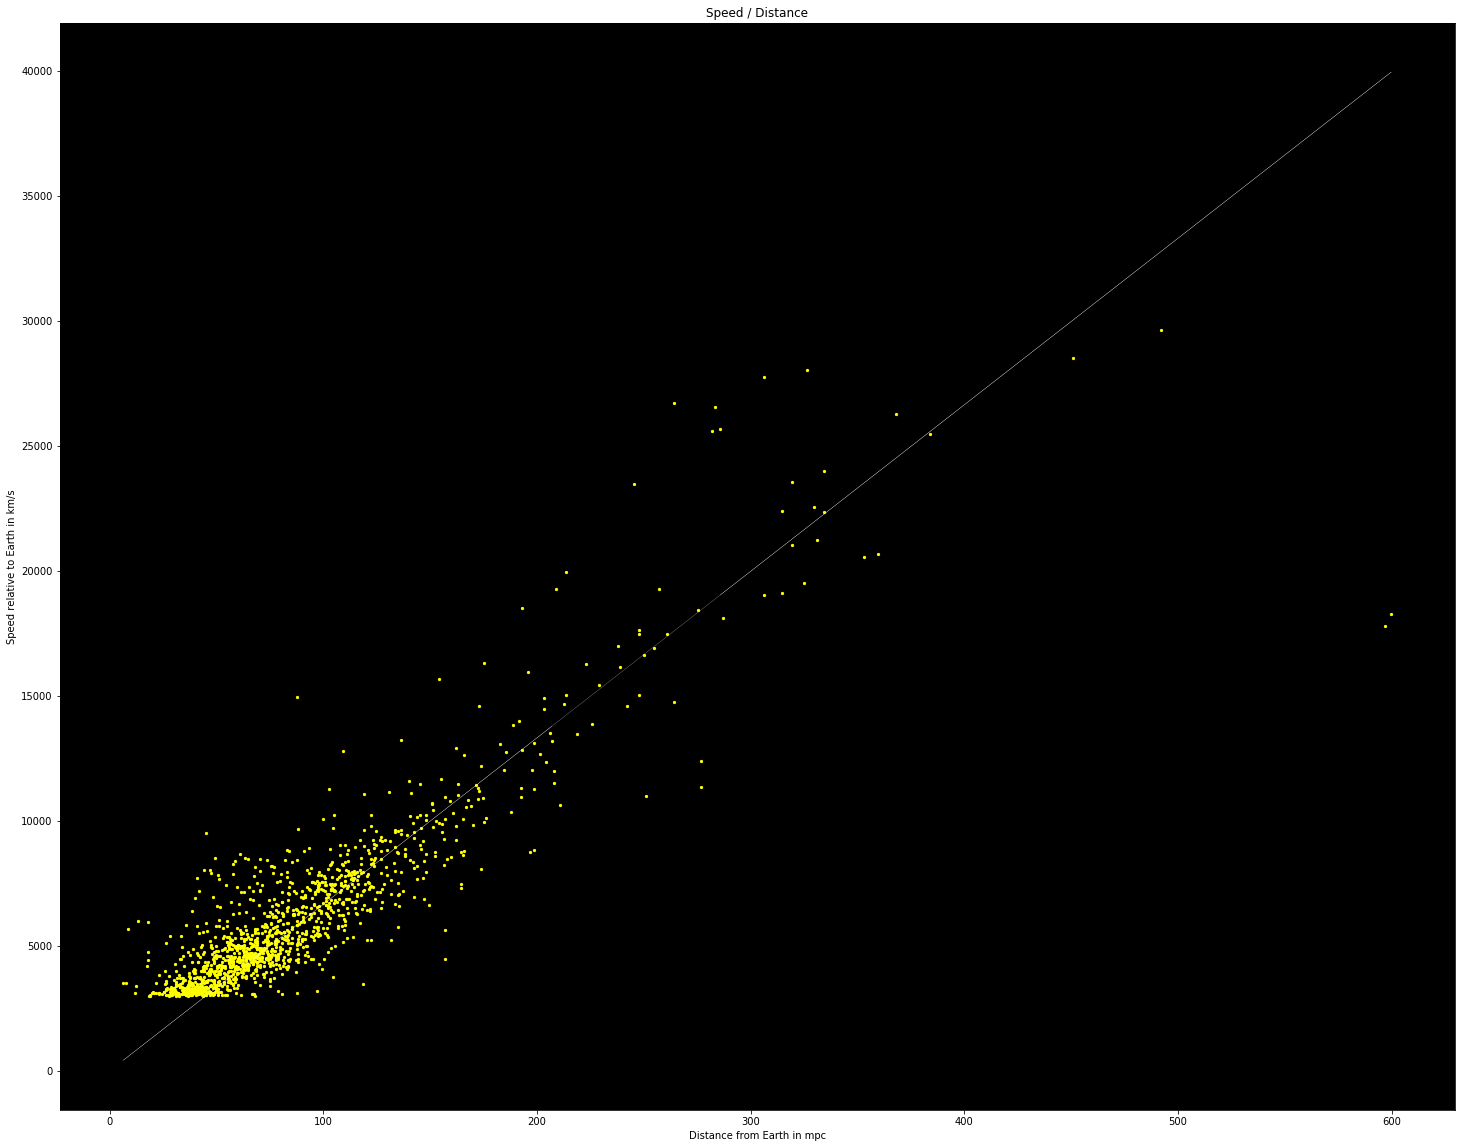

In [15]:
# Least Square Best Fit line
f = lambda x: a * x

# Initialize plot and subplot
fig2 = plt.figure(figsize=(25,20))
g2 = fig2.add_subplot(1, 1, 1)

# Set background color to black
g2.set_facecolor((0, 0, 0))

# Plot dataset
g2.scatter(df['d_mpc'], df['v3k'], c='yellow', s=5)

# Plot best fit line
g2.plot(x,f(x), c="white", label="fit line", linewidth=0.2)

# Add labels
g2.set_title('Speed / Distance')  
g2.set_xlabel('Distance from Earth in mpc')  
g2.set_ylabel('Speed relative to Earth in km/s')  

# Show plot
plt.show()